# Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

The DBSCAN algorithm is a clustering algorithm that works really well for datasets that have regions of high density.

The model can take array-like objects, either in host as NumPy arrays or in device (as Numba or cuda_array_interface-compliant), as well  as cuDF DataFrames.

For information about the cuDF format, refer to the [cuDF documentation](https://rapidsai.github.io/projects/cudf/en/latest/)

For information about cuML's DBSCAN implementation: https://rapidsai.github.io/projects/cuml/en/latest/api.html#dbscan

In [24]:
import os

import numpy as np


from sklearn import datasets

import pandas as pd
import cudf as gd

from sklearn.datasets import make_blobs

from sklearn.metrics import adjusted_rand_score

from sklearn.cluster import DBSCAN as skDBSCAN
from cuml.cluster import DBSCAN as cumlDBSCAN

## Define Parameters

In [13]:
n_samples = 100000
n_features = 2

eps = 0.15
min_samples = 3

## Generate Data

### Host

In [14]:
host_data, host_labels = make_blobs(
   n_samples=n_samples, n_features=n_features, centers=5, cluster_std=0.1)

host_data = host_data
print(str(host_data.dtype))

host_data = pd.DataFrame(host_data)
host_labels = pd.Series(host_labels)

float64


### Device

In [15]:
device_data = gd.DataFrame.from_pandas(host_data)
device_labels = gd.Series(host_labels)

## Scikit-learn Model

In [16]:
%%time
clustering_sk = skDBSCAN(eps=eps,
                         min_samples=min_samples,
                         algorithm="brute",
                         n_jobs=-1)
clustering_sk.fit(host_data)

CPU times: user 14min 43s, sys: 21min, total: 35min 43s
Wall time: 3min 17s


DBSCAN(algorithm='brute', eps=0.15, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=3, n_jobs=-1, p=None)

## cuML Model

In [18]:
%%time
clustering_cuml = cumlDBSCAN(eps=eps,
                             min_samples=min_samples,
                             verbose=True)
clustering_cuml.fit(device_data)

CPU times: user 4.84 s, sys: 3.28 s, total: 8.13 s
Wall time: 8.14 s


DBSCAN(eps=0.15, handle=<cuml.common.handle.Handle object at 0x7f5fac319048>, min_samples=3, verbose=True, max_bytes_per_batch=0)

## Visualize Centroids

Chart the resulting clusters from cuML's `DBSCAN`

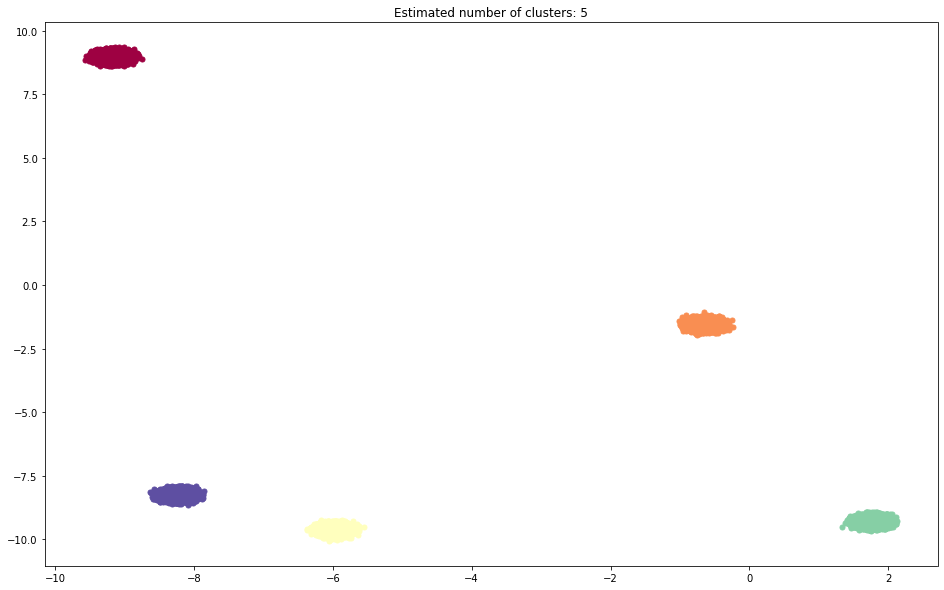

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(16, 10))

X = np.array(host_data)
labels = clustering_cuml.labels_.values

n_clusters_ = len(clustering_cuml.labels_.unique())


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markersize=5, markeredgecolor=tuple(col))

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Evaluate Results

Use the `adjusted_rand_score` to compare the two results, making sure the clusters are labeled similarly by both algorithms even if the exact numerical labels are not identical. 

In [ ]:
%%time
cuml_score = adjusted_rand_score(host_labels, clustering_cuml.labels_)
sk_score = adjusted_rand_score(host_labels, clustering_sk.labels_)

/share/conda/cuml4/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:  The dtype of ground truth is not int32 converting the ground truth to int32
  """Entry point for launching an IPython kernel.
/share/conda/cuml4/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:  The dtype of predicted labels is not int32 converting the predicted labels to int32
  """Entry point for launching an IPython kernel.


In [25]:
passed = (cuml_score - sk_score) < 1e-10
print('compare dbscan: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))

compare dbscan: cuml vs sklearn labels_ are equal
